In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from gensim.models import Word2Vec
import xgboost as xgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, KFold, GroupKFold
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, log_loss, mean_squared_log_error
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
import tqdm
import sys
import os
import gc
import argparse
import warnings
import lightgbm as lgb
from lightgbm import early_stopping
from lightgbm import log_evaluation
from sklearn.model_selection import StratifiedKFold, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import pickle
#计算shap值
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif']=['SimHei']

## 读取数据

In [2]:
jy_df=pd.read_csv('data/账户交易信息.csv')
jy_df.columns = ['交易流水序号','账户代号','对方账号','借贷标志','交易金额','交易余额','对方行号','交易日期','交易时间','交易渠道','摘要代号','对方名称长度']
jt_df=pd.read_csv('data/账户静态信息.csv')
jt_df.columns = ['账户代号','开户日期','开户行代号','客户性别','年龄']
train_label=pd.read_csv('data/训练集标签.csv')
train_label.columns = ['账户代号','label']
test_df=pd.read_csv('data/test_dataset.csv')
test_df.columns = ['账户代号']## 读取数据

In [3]:
df_all=pd.concat([train_label,test_df])

## 抹账数据预处理

In [4]:
jy_mz_df=jy_df[jy_df['账户代号'].isin(jy_df[jy_df['交易金额']<0]['账户代号'].unique())].sort_values(by=['账户代号','交易日期','交易时间'],ascending=True)
jy_mz_df.index=range(len(jy_mz_df))
#待剔除数据
tc_idx=set()
for idx in jy_mz_df[jy_mz_df['交易金额']<0].index:
    for d in range(1,5):
        #print(idx)
        if -jy_mz_df.loc[idx,'交易金额']==jy_mz_df.loc[idx-d,'交易金额'] and jy_mz_df.loc[idx,'账户代号']==jy_mz_df.loc[idx-d,'账户代号']\
            and jy_mz_df.loc[idx,'对方账号']==jy_mz_df.loc[idx-d,'对方账号']:
                tc_idx.add(idx)
                tc_idx.add(idx-d)
                break
tc_idx=list(tc_idx)
jy_clean_df=jy_mz_df[~jy_mz_df.index.isin(tc_idx)]
jy_clean_df=pd.concat([jy_clean_df,jy_df[jy_df['交易金额']>=0]])

In [5]:
## 时间特征

def 获取时间特征(df, col):
    
    df_copy = df.copy()
    prefix = col + "_"
    df_copy['new_'+col] = df_copy[col].astype(str)
    
    col = 'new_'+col
    df_copy[col] = pd.to_datetime(df_copy[col], format='%Y-%m-%d')
    df_copy[prefix + 'month'] = df_copy[col].dt.month
    df_copy[prefix + 'day'] = df_copy[col].dt.day
    #df_copy[prefix + 'weekofyear'] = df_copy[col].dt.weekofyear
    #df_copy[prefix + 'dayofyear'] = df_copy[col].dt.dayofyear
    #df_copy[prefix + 'dayofweek'] = df_copy[col].dt.dayofweek
    df_copy[prefix + 'is_wknd'] = df_copy[col].dt.dayofweek.apply(lambda x:1 if x in [5,6] else 0)
    df_copy[prefix + 'is_month_start'] = df_copy[col].dt.is_month_start.astype(int)
    df_copy[prefix + 'is_month_end'] = df_copy[col].dt.is_month_end.astype(int)
    
    
    df_copy[prefix + 'is_前5天'] = df_copy[prefix + 'day'].apply(lambda x: 1 if x<=5 else 0 )
    df_copy[prefix + 'is_后5天'] = df_copy[prefix + 'day'].apply(lambda x: 1 if x>=25 else 0)
    df_copy[prefix + 'is_贷款还款日'] = df_copy[prefix + 'day'].apply(lambda x: 1 if x==22 else 0)
    del df_copy[col]
    
    df_copy[prefix + 'hour'] = df_copy['交易时间'].apply(lambda x:int(x.split(':')[0]))
    df_copy[prefix + 'minu'] = df_copy['交易时间'].apply(lambda x:int(x.split(':')[1]))
    #df_copy[prefix + 'date'] = df_copy['交易时间'].apply(lambda x:int(x.split(':')[0])*60 + int(x.split(':')[1]))
    df_copy[prefix + 'ismidnight']=df_copy[prefix + 'hour'].apply(lambda x: 1 if x>=23 or x<=4 else 0)
    df_copy[prefix + 'isworktime']=df_copy[prefix + 'hour'].apply(lambda x: 1 if x>=8 and x<=18 else 0)
    
    #del df_copy['交易时间']
    df_copy.drop([prefix + 'month',prefix + 'day',prefix + 'hour',prefix + 'minu','交易时间'],axis=1,inplace=True)
    return df_copy
jy_clean_df = 获取时间特征(jy_clean_df, "交易日期")
#jy_df       = 获取时间特征(jy_df, "交易日期")




In [6]:
def 按时间特征聚合(df1_, df2_):
    df1 = df1_.copy() #交易流水 
    df2 = df2_.copy()
    time_cols = [f for f in df1.columns if '交易日期_' in f]
    df_all=df2

    agg_func = {
        '对方账号': ['nunique','count'],
        '对方行号': ['nunique'],
        '交易渠道': ['nunique'],
        '摘要代号': ['nunique'],
        '交易金额': ['sum','mean','max','min','std',np.ptp],
        '交易余额': ['sum','mean','max','min','std',np.ptp],
        '对方名称长度': ['mean','max','min',np.ptp],
    }
    df1_bak=df1.copy()
    for col in time_cols:
        df1=df1_bak[df1_bak[col]==1]
        
        agg_df0 = df1.groupby(['账户代号']).agg(agg_func).reset_index()
        agg_df0.columns = ['账户代号'] + ['账户代号_流量_' +col+ '_'.join(f).strip() for f in agg_df0.columns.values if f[0] not in ['账户代号']]

        agg_df1 = df1[df1['借贷标志']==0].groupby(['账户代号']).agg(agg_func).reset_index()
        agg_df1.columns = ['账户代号'] + ['账户代号_流出_' +col+ '_'.join(f).strip() for f in agg_df1.columns.values if f[0] not in ['账户代号']]


        agg_df2 = df1[df1['借贷标志']==1].groupby(['账户代号']).agg(agg_func).reset_index()
        agg_df2.columns = ['账户代号'] + ['账户代号_流入_' +col+ '_'.join(f).strip() for f in agg_df2.columns.values if f[0] not in ['账户代号']]

    
    
        df_all=pd.merge(df_all,agg_df0,on='账户代号',how='left')
        df_all=pd.merge(df_all,agg_df1,on='账户代号',how='left')
        df_all=pd.merge(df_all,agg_df2,on='账户代号',how='left')
    
        #for idx,c2 in enumerate(agg_df2.columns):
        #    if idx>=1:
        #        c1=agg_df1.columns[idx]
#
        #        df_all[c2+'-'+c1]=df_all[c2]-df_all[c1]
        #        df_all[c2+'/'+c1]=df_all[c2]/(df_all[c1]+1)
        #        c0=agg_df0.columns[idx]
        #        df_all[c1+'/'+c0]=df_all[c1]/(df_all[c0]+1)
        #        df_all[c2+'/'+c0]=df_all[c2]/(df_all[c0]+1)
    
    #tfid_vec = TfidfVectorizer()
    #qd_vector = tfid_vec.fit_transform(df1_bak['交易渠道'])
    #weight = qd_vector.toarray()
    #word = tfid_vec.get_feature_names_out()
    #qd_df=pd.DataFrame(weight,columns=[c+'_渠道' for c in word])
    #qd_df.index=df1_bak.index
    #qd_df['账户代号']=df1_bak['账户代号']
    #cols=[c for c in qd_df.columns if c not in ['账户代号']]
    #agg_df3=qd_df.groupby(['账户代号'])[cols].agg(['sum'])
    #agg_df3.columns=["_".join(x) for x in agg_df3.columns.ravel()]
    #agg_df3=agg_df3.reset_index()
    #df_all=pd.merge(df_all,agg_df3,on='账户代号',how='left')
    return df_all
df_sjgroup_clean=按时间特征聚合(jy_clean_df,df_all['账户代号'])
pickle.dump(df_sjgroup_clean,open('df_sjgroup_clean.pkl', 'wb'))

In [7]:
def 时间滑窗特征聚合(df1_,df2_):
    df1 = df1_.copy() #交易流水 
    df2 = df2_.copy()
    df1_maxrq=df1.groupby(['账户代号'])['交易日期'].max().reset_index()
    df1_maxrq.columns=['账户代号','最近交易日期']
    df1=pd.merge(df1,df1_maxrq,on='账户代号',how='left') 
    
    time_cols = [f for f in df1.columns if '交易日期_' in f]

    agg_func = {
        '对方账号': ['nunique','count'],
        '对方行号': ['nunique'],
        '交易渠道': ['nunique'],
        '摘要代号': ['nunique'],
        '交易金额': ['sum','mean','max','min','std',np.ptp],
        '交易余额': ['sum','mean','max','min','std',np.ptp],
        '对方名称长度': ['mean','max','min',np.ptp],
    }
    df1['date_diff']=(pd.to_datetime(df1['最近交易日期'],format='%Y-%m-%d')-pd.to_datetime(df1['交易日期'],format='%Y-%m-%d')).dt.days
    df1_bak=df1.copy()
    
    df_all=df2
    for col in time_cols:
        df1=df1_bak[df1_bak[col]==1]
        for i in [7,16,31,60]:
            agg_df0 = df1.groupby(['账户代号']).agg(agg_func).reset_index()
            agg_df0.columns = ['账户代号'] + ['账户代号_流量_'+str(i)+'天以内'+'_' +col+ '_'.join(f).strip() for f in agg_df0.columns.values if f[0] not in ['账户代号']]

            agg_df1 = df1[df1['借贷标志']==0].groupby(['账户代号']).agg(agg_func).reset_index()
            agg_df1.columns = ['账户代号'] + ['账户代号_流出_'+str(i)+'天以内' +'_'+ col+'_'.join(f).strip() for f in agg_df1.columns.values if f[0] not in ['账户代号']]


            agg_df2 = df1[df1['借贷标志']==1].groupby(['账户代号']).agg(agg_func).reset_index()
            agg_df2.columns = ['账户代号'] + ['账户代号_流入_'+str(i)+'天以内' +'_'+ col+'_'.join(f).strip() for f in agg_df2.columns.values if f[0] not in ['账户代号']]



            df_all=pd.merge(df_all,agg_df0,on='账户代号',how='left')
            df_all=pd.merge(df_all,agg_df1,on='账户代号',how='left')
            df_all=pd.merge(df_all,agg_df2,on='账户代号',how='left')

            #for idx,c2 in enumerate(agg_df2.columns):
            #    if idx>=1:
            #        c1=agg_df1.columns[idx]
#
            #        df_all[c2+'-'+c1]=df_all[c2]-df_all[c1]
            #        df_all[c2+'/'+c1]=df_all[c2]/(df_all[c1]+1)
            #        c0=agg_df0.columns[idx]
            #        df_all[c1+'/'+c0]=df_all[c1]/(df_all[c0]+1)
            #        df_all[c2+'/'+c0]=df_all[c2]/(df_all[c0]+1)
        
    return df_all

df_sjhc_clean = 时间滑窗特征聚合(jy_clean_df,df_all['账户代号'])


pickle.dump(df_sjhc_clean,open('df_sjhc_clean.pkl', 'wb'))


In [8]:
%%time
def 账户基础信息(df1_):
    df1 = df1_.copy() #基本信息
    
    df1['开户日期']  = pd.to_datetime(df1['开户日期'], format='%Y-%m-%d')
    df1['开户日期_year']  = df1['开户日期'].dt.year
    df1['开户日期_month'] = df1['开户日期'].dt.month
    df1['开户日期_day']   = df1['开户日期'].dt.day
    del df1['开户日期']
    return df1




Wall time: 0 ns


In [9]:
df_sjgroup_clean = pickle.load(open('df_sjgroup_clean.pkl', 'rb'))
df_sjhc_clean = pickle.load(open('df_sjhc_clean.pkl', 'rb'))

In [10]:
jy_df=pd.read_csv('data/账户交易信息.csv')
jy_df.columns = ['交易流水序号','账户代号','对方账号','借贷标志','交易金额','交易余额','对方行号','交易日期','交易时间','交易渠道','摘要代号','对方名称长度']
jt_df=pd.read_csv('data/账户静态信息.csv')
jt_df.columns = ['账户代号','开户日期','开户行代号','客户性别','年龄']
train_label=pd.read_csv('data/训练集标签.csv')
train_label.columns = ['账户代号','label']
test_df=pd.read_csv('data/test_dataset.csv')
test_df.columns = ['账户代号']
df_all=pd.concat([train_label,test_df])
jt_df = 账户基础信息(jt_df)
df_all=df_all.merge(jt_df,on='账户代号',how='left')
df_all=df_all.merge(df_sjgroup_clean,on='账户代号',how='left')
df_all=df_all.merge(df_sjhc_clean,on='账户代号',how='left')

In [11]:
#catboost编码
def cat_encode(df_train_,df_test_):
    df_train=df_train_.copy()
    df_test=df_test_.copy()
    cat_feature_lists=['开户行代号']
    for cat_feature in cat_feature_lists:
        target_enc = ce.CatBoostEncoder(cols=cat_feature,a=200)
        target_enc.fit(df_train[cat_feature], df_train['label'])
    #Transform the features, rename columns with _cb suffix, and join to dataframe
        df_train[cat_feature] = target_enc.transform(df_train[cat_feature]).add_suffix('_cb')
        df_test[cat_feature] = target_enc.transform(df_test[cat_feature]).add_suffix('_cb')

    return df_train,df_test

train_label,test_label = cat_encode(df_all[:len(train_label)],df_all[len(train_label):])


In [30]:
df_all.head()

,账户代号,label,开户行代号,客户性别,年龄,开户日期_year,开户日期_month,开户日期_day,账户代号_流量_交易日期_is_wknd对方账号_nunique,账户代号_流量_交易日期_is_wknd对方账号_count,...,账户代号_流入_60天以内_交易日期_isworktime交易余额_sum,账户代号_流入_60天以内_交易日期_isworktime交易余额_mean,账户代号_流入_60天以内_交易日期_isworktime交易余额_max,账户代号_流入_60天以内_交易日期_isworktime交易余额_min,账户代号_流入_60天以内_交易日期_isworktime交易余额_std,账户代号_流入_60天以内_交易日期_isworktime交易余额_ptp,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_mean,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_max,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_min,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_ptp
0,2029FF26D4E2CA79,0.0,698D51A1,1,40,2018,3,28,3.0,7.0,...,4799997.18,599999.647500,751277.54,438851.49,137585.288971,312426.05,5.250000,6.0,0.0,6.0
1,09F5B90D46FB7CCE,1.0,B6A1085A,0,39,2018,2,27,21.0,46.0,...,9638537.14,49176.209898,173292.44,340.44,45545.234988,172952.00,9.704082,33.0,6.0,27.0
2,E0C880EB18F4EFE8,1.0,5E9F92A0,0,24,2019,5,25,5.0,6.0,...,1234410.56,77150.660000,210062.91,22.91,70690.046367,210040.00,11.437500,33.0,6.0,27.0
3,ED8FFDCCF93C2F11,1.0,577BCC91,0,30,2017,1,17,28.0,78.0,...,284.00,71.000000,131.75,10.25,70.148058,121.50,7.500000,9.0,6.0,3.0
4,8D2F48B0BFC40AB2,1.0,816B112C,0,30,2020,5,13,4.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
train_label.head()

,账户代号,label,开户行代号,客户性别,年龄,开户日期_year,开户日期_month,开户日期_day,账户代号_流量_交易日期_is_wknd对方账号_nunique,账户代号_流量_交易日期_is_wknd对方账号_count,...,账户代号_流入_60天以内_交易日期_isworktime交易余额_sum,账户代号_流入_60天以内_交易日期_isworktime交易余额_mean,账户代号_流入_60天以内_交易日期_isworktime交易余额_max,账户代号_流入_60天以内_交易日期_isworktime交易余额_min,账户代号_流入_60天以内_交易日期_isworktime交易余额_std,账户代号_流入_60天以内_交易日期_isworktime交易余额_ptp,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_mean,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_max,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_min,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_ptp
0,2029FF26D4E2CA79,0.0,0.248804,1,40,2018,3,28,3.0,7.0,...,4799997.18,599999.647500,751277.54,438851.49,137585.288971,312426.05,5.250000,6.0,0.0,6.0
1,09F5B90D46FB7CCE,1.0,0.256158,0,39,2018,2,27,21.0,46.0,...,9638537.14,49176.209898,173292.44,340.44,45545.234988,172952.00,9.704082,33.0,6.0,27.0
2,E0C880EB18F4EFE8,1.0,0.250000,0,24,2019,5,25,5.0,6.0,...,1234410.56,77150.660000,210062.91,22.91,70690.046367,210040.00,11.437500,33.0,6.0,27.0
3,ED8FFDCCF93C2F11,1.0,0.257009,0,30,2017,1,17,28.0,78.0,...,284.00,71.000000,131.75,10.25,70.148058,121.50,7.500000,9.0,6.0,3.0
4,8D2F48B0BFC40AB2,1.0,0.257143,0,30,2020,5,13,4.0,48.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
test_label.head()

,账户代号,label,开户行代号,客户性别,年龄,开户日期_year,开户日期_month,开户日期_day,账户代号_流量_交易日期_is_wknd对方账号_nunique,账户代号_流量_交易日期_is_wknd对方账号_count,...,账户代号_流入_60天以内_交易日期_isworktime交易余额_sum,账户代号_流入_60天以内_交易日期_isworktime交易余额_mean,账户代号_流入_60天以内_交易日期_isworktime交易余额_max,账户代号_流入_60天以内_交易日期_isworktime交易余额_min,账户代号_流入_60天以内_交易日期_isworktime交易余额_std,账户代号_流入_60天以内_交易日期_isworktime交易余额_ptp,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_mean,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_max,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_min,账户代号_流入_60天以内_交易日期_isworktime对方名称长度_ptp
1200,B6751CD225DD4886,0,0.250000,1,41,2018,12,12,4.0,16.0,...,14501.02,4833.673333,8588.96,912.06,3841.151757,7676.90,32.000000,45.0,6.0,39.0
1201,8265CA869E4AFF16,0,0.250000,0,43,2018,1,21,16.0,54.0,...,46410.54,2578.363333,10264.28,38.49,3914.794751,10225.79,23.833333,45.0,0.0,45.0
1202,06DD2A17463919FC,0,0.246305,1,30,2012,6,15,7.0,17.0,...,553617.09,42585.930000,155017.58,19.60,53772.789333,154997.98,4.846154,9.0,0.0,9.0
1203,F36469EA4C5BD7FC,0,0.250000,0,43,2019,10,30,4.0,6.0,...,11300.00,3766.666667,5600.00,100.00,3175.426481,5500.00,9.000000,9.0,9.0,0.0
1204,A18F7ACD7A3853D1,0,0.251232,1,25,2015,9,12,7.0,16.0,...,282014.92,23501.243333,64534.94,6309.00,16752.154802,58225.94,21.750000,63.0,0.0,63.0


## 特征筛选-共线性

In [12]:
def corr_filter(train_data,corr_threshold):
    corr_data=train_data.corr()
    corr_data=corr_data.where(np.triu(np.ones(corr_data.shape),k=1).astype(np.bool))
    high_corr=[column for column in corr_data.columns if any(corr_data[column].abs()>corr_threshold)]
    result=[c for c in train_data.columns if c not in high_corr]
    print("筛选后特征:",len(result))
    return result


In [13]:
cols = [f for f in train_label.columns if f not in ['账户代号','label']]
cols =corr_filter(train_label[cols],0.95)

筛选后特征: 343


## 特征筛选-对抗验证筛选

In [14]:
def 对抗验证获取数据(df_train,df_test,threshold):
    # 定义新的Y
    
    
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1
    #print(df_train.columns)
    #print(df_test.columns)
    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])
    #print(df_adv.columns)
    #catecol_list_index=[list(df_train.columns).index(c) for c in df_train.select_dtypes(include=['category']).columns]
    # 通过抗验证中的模型，得到各个样本属于测试集的概率


    
    model_adv =  lgb.LGBMClassifier()
    model_adv.fit(df_adv.drop(['label','Is_Test'], axis=1), df_adv.loc[:, 'Is_Test'])
    preds_adv = model_adv.predict_proba(df_adv.drop(['label','Is_Test'], axis=1))[:, 1]
    
    df_train_copy = df_train.copy()
    df_train_copy['is_test_prob'] = preds_adv[:len(df_train)]

    # 根据概率排序
    df_train_copy = df_train_copy.sort_values('is_test_prob').reset_index(drop=True)

    # 将概率最大的20%作为验证集
    df_validation_2 = df_train_copy.iloc[int(threshold * len(df_train)):, ]
    df_train_2 = df_train_copy.iloc[:int(threshold * len(df_train)), ]
    return df_validation_2.drop(['is_test_prob','Is_Test'], axis=1)#,df_train_copy.drop(['Is_Test'],axis=1)
def 对抗验证获得新的列(df_train,df_test,threshold):
    # 定义新的Y
    df_train['Is_Test'] = 0
    df_test['Is_Test'] = 1

    # 将 Train 和 Test 合成一个数据集。
    df_adv = pd.concat([df_train, df_test])

    # 通过抗验证中的模型，得到各个样本属于测试集的概率
    other_param={'boosting_type':'gbdt','num_leaves':32,'max_depth':10,'n_estimators':200,'objective':'binary','subsample':0.7,'colsample_bytree':0.8,'subsample_freq':1,
               'min_child_weight':0.9,'learning_rate':0.08}
    model_adv =  lgb.LGBMClassifier(**other_param)
    model_adv.fit(df_adv.drop('Is_Test', axis=1), df_adv.loc[:, 'Is_Test'])
    #preds_adv = model_adv.predict_proba(df_adv.drop('Is_Test', axis=1))[:, 1]
    
    im=pd.DataFrame({'colname':df_train.drop(['Is_Test'],axis=1).columns,'importance':model_adv.feature_importances_})

    im=im.sort_values(by='importance',ascending=False)
        
    new_cat=im.reset_index().loc[round(len(im)*threshold):,'colname']
    print('对抗验证后的特征数量为:',len(new_cat))
    return new_cat

In [15]:
#cols_bak=pd.read_csv('./特征列表.csv')
#cols=cols_bak['0']


In [16]:
new_cat=对抗验证获得新的列(train_label[cols].copy(),test_label[cols].copy(),0.6)
cols=list(new_cat)
col_valid=cols.copy()
col_valid.append('label')
valid=对抗验证获取数据(train_label[col_valid].copy(),test_label[cols].copy(),0.8)

对抗验证后的特征数量为: 137


In [24]:
new_cat.head()

206    账户代号_流量_交易日期_is_month_start交易金额_mean
207     账户代号_流出_交易日期_ismidnight对方账号_nunique
208       账户代号_流出_交易日期_ismidnight对方名称长度_ptp
209       账户代号_流入_交易日期_is_贷款还款日交易渠道_nunique
210         账户代号_流量_交易日期_is_贷款还款日对方名称长度_max
Name: colname, dtype: object

In [17]:
def cv_model(clf, train_x, train_y, test_x, clf_name,valid_x):
    folds = 5
    seed = 2023
    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)
    
    oof = np.zeros(train_x.shape[0])
    predict = np.zeros(test_x.shape[0])
    predict_valid = np.zeros(valid_x.shape[0])
    cv_scores = []

    for i, (train_index, valid_index) in enumerate(kf.split(train_x, train_y)):
        print('************************************ {} ************************************'.format(str(i+1)))
        trn_x, trn_y, val_x, val_y = train_x.iloc[train_index], train_y[train_index], train_x.iloc[valid_index], train_y[valid_index]

        if clf_name == "lgb":
            train_matrix = clf.Dataset(trn_x, label=trn_y)
            valid_matrix = clf.Dataset(val_x, label=val_y)

            params = {
                'boosting_type': 'gbdt',
                'objective': 'binary',
                'metric': 'auc',
                'min_child_weight': 5,
                'num_leaves': 2 ** 5,
                'lambda_l2': 10,
                'feature_fraction': 0.8,
                'bagging_fraction': 0.8,
                'bagging_freq': 4,
                'learning_rate': 0.01,
                'seed': 2020,
                'n_jobs':8
            }

            model = clf.train(params, train_matrix, 10000, valid_sets=[train_matrix, valid_matrix], 
                              categorical_feature=[], verbose_eval=200, early_stopping_rounds=200)
            val_pred = model.predict(val_x, num_iteration=model.best_iteration)
            test_pred = model.predict(test_x, num_iteration=model.best_iteration)
            
            print(list(sorted(zip(features, model.feature_importance("gain")), key=lambda x: x[1], reverse=True))[:20])
                
        if clf_name == "xgb":
            train_matrix = clf.DMatrix(trn_x , label=trn_y)
            valid_matrix = clf.DMatrix(val_x , label=val_y)
            test_matrix = clf.DMatrix(test_x)
            
            params = {'booster': 'gbtree',
                      'objective': 'binary:logistic',
                      'eval_metric': 'auc',
                      'gamma': 1,
                      'min_child_weight': 1.5,
                      'max_depth': 5,
                      'lambda': 10,
                      'subsample': 0.7,
                      'colsample_bytree': 0.7,
                      'colsample_bylevel': 0.7,
                      'eta': 0.05,
                      'tree_method': 'exact',
                      'seed': 2020,
                      'nthread': 8
                      }
            
            watchlist = [(train_matrix, 'train'),(valid_matrix, 'eval')]
            
            model = clf.train(params, train_matrix, num_boost_round=10000, evals=watchlist, verbose_eval=1000, early_stopping_rounds=500)
            val_pred  = model.predict(valid_matrix, ntree_limit=model.best_ntree_limit)
            test_pred = model.predict(test_matrix , ntree_limit=model.best_ntree_limit)
            
            valid_dk_matrix = clf.DMatrix(valid_x)
            valid_pred= model.predict(valid_dk_matrix, ntree_limit=model.best_ntree_limit)
        if clf_name == "cat":
            model = clf(
                        n_estimators=10000,
                        random_seed=2023,
                        eval_metric='AUC',
                        learning_rate=0.05,
                        max_depth=7,
                        early_stopping_rounds=200,
                        metric_period=500,
                    )

            model.fit(trn_x, trn_y, eval_set=(val_x, val_y),
                      use_best_model=True,
                      verbose=1)
            
            val_pred  = model.predict_proba(val_x)[:,1]
            test_pred = model.predict_proba(test_x)[:,1]
            valid_pred= model.predict_proba(valid_x)[:,1]
            
        oof[valid_index] = val_pred
        predict += test_pred / kf.n_splits
        predict_valid +=valid_pred / kf.n_splits
        cv_scores.append(roc_auc_score(val_y, val_pred))
        print(cv_scores)
       
    return oof, predict,predict_valid,model

In [18]:
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid[cols])
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[cols], train_label['label'], test_label[cols], 'xgb',valid[cols])


************************************ 1 ************************************


0:	test: 0.7840741	best: 0.7840741 (0)	total: 168ms	remaining: 27m 55s
500:	test: 0.9323148	best: 0.9350926 (387)	total: 4.43s	remaining: 1m 24s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9350925926
bestIteration = 387

Shrink model to first 388 iterations.
[0.9350925925925926]
************************************ 2 ************************************


0:	test: 0.7287963	best: 0.7287963 (0)	total: 6.17ms	remaining: 1m 1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9225925926
bestIteration = 49

Shrink model to first 50 iterations.
[0.9350925925925926, 0.9225925925925926]
************************************ 3 ************************************


0:	test: 0.7637037	best: 0.7637037 (0)	total: 12.6ms	remaining: 2m 6s
500:	test: 0.9180556	best: 0.9189815 (418)	total: 4.27s	remaining: 1m 20s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9189814815
bestIteration = 418

Shrink model to first 419 iterations.
[0.9350925925925926, 0.9225925925925926, 0.9189814814814815]
************************************ 4 ************************************


0:	test: 0.7631019	best: 0.7631019 (0)	total: 11ms	remaining: 1m 50s
500:	test: 0.9259259	best: 0.9272222 (397)	total: 3.55s	remaining: 1m 7s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9272222222
bestIteration = 397

Shrink model to first 398 iterations.
[0.9350925925925926, 0.9225925925925926, 0.9189814814814815, 0.9272222222222223]
************************************ 5 ************************************
0:	test: 0.8678704	best: 0.8678704 (0)	total: 5.51ms	remaining: 55.1s


Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.9418518519
bestIteration = 159

Shrink model to first 160 iterations.
[0.9350925925925926, 0.9225925925925926, 0.9189814814814815, 0.9272222222222223, 0.9418518518518519]


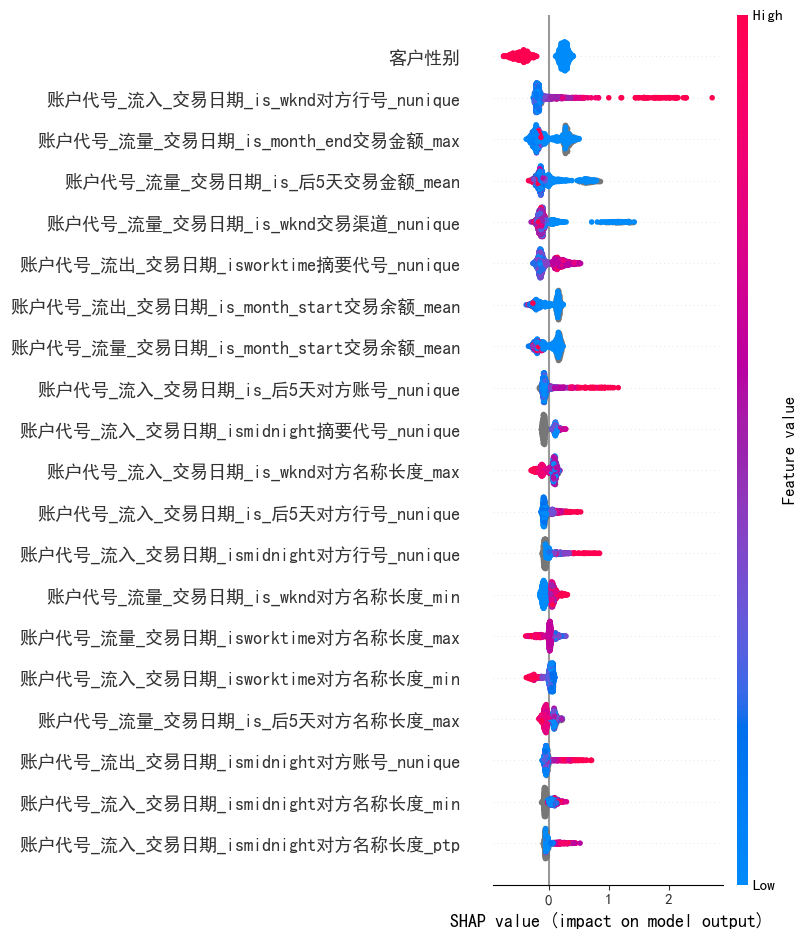

In [19]:

explainer = shap.TreeExplainer(clf)

shap_values = explainer.shap_values(train_label[cols])
#shap.summary_plot(shap_values[1], train_label[cols])
shap.summary_plot(shap_values, train_label[cols])

In [20]:
wrap_features=pd.DataFrame()
wrap_features['cols']=cols
wrap_features['shap']=abs(shap_values).sum(axis=0)
wrap_features.sort_values(by='shap',ascending=False,inplace=True)
wrap_features.index=range(len(wrap_features))
wrap_features=wrap_features[:100]['cols']

In [21]:
#xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(CatBoostClassifier, train_label[cols], train_label['label'], test_label[cols], 'cat',valid.drop('label',axis=1))
xgb_oof, xgb_pred,xgb_valid_pred,clf = cv_model(xgb, train_label[wrap_features], train_label['label'], test_label[wrap_features], 'xgb',valid[wrap_features])

************************************ 1 ************************************
[0]	train-auc:0.85825	eval-auc:0.81093
[1000]	train-auc:0.99929	eval-auc:0.94111
[1254]	train-auc:0.99937	eval-auc:0.94019
[0.9419444444444444]
************************************ 2 ************************************
[0]	train-auc:0.83324	eval-auc:0.77699
[652]	train-auc:0.99913	eval-auc:0.91120
[0.9419444444444444, 0.9175925925925926]
************************************ 3 ************************************
[0]	train-auc:0.84259	eval-auc:0.77884
[685]	train-auc:0.99873	eval-auc:0.90935
[0.9419444444444444, 0.9175925925925926, 0.912962962962963]
************************************ 4 ************************************
[0]	train-auc:0.86573	eval-auc:0.82699
[951]	train-auc:0.99913	eval-auc:0.93056
[0.9419444444444444, 0.9175925925925926, 0.912962962962963, 0.9324999999999999]
************************************ 5 ************************************
[0]	train-auc:0.83198	eval-auc:0.85167
[746]	train-auc:

In [22]:
oof = xgb_oof
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.6,0.01):
    preds = (oof.reshape((-1))>threshold).astype('int')
    m = f1_score(train_label['label'].values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold
    print(f'{threshold:.02f}, {m}')
print(f'最高分:{best_threshold:.2f}, {best_score}')

m_valid = f1_score(valid['label'].values, (xgb_valid_pred>best_threshold).astype('int'), average='macro')   

print(f'对抗验证分:{m_valid}')
# 0.47, 0.9150898680694286 # 0.86579572447
# 0.43, 0.9217716422203048 # 0.86697783
# 0.41, 0.9198568108353592 # 0.87674418605
# 0.40, 0.9231997065541027 # 0.87819025522
# 0.42, 0.913822737200522  # 0.87639132982 
# 0.40, 0.9148403872302214 # 0.88313184

0.40, 0.8645622601030579
0.41, 0.8684931506849315
0.42, 0.8665516249640495
0.43, 0.8659016380808521
0.44, 0.8632549946692626
0.45, 0.8615848534282466
0.46, 0.8575648255169113
0.47, 0.8611895351025787
0.48, 0.8594763427242105
0.49, 0.86047831501947
0.50, 0.8601183067202485
0.51, 0.8566308243727598
0.52, 0.8576383315770741
0.53, 0.854862554239123
0.54, 0.8534687079623342
0.55, 0.8520708576582897
0.56, 0.850668978888929
0.57, 0.8470279720279721
0.58, 0.8408676385981664
0.59, 0.8399796486937825
最高分:0.41, 0.8684931506849315
对抗验证分:0.9473337722185649


In [23]:
pred = xgb_pred
test_label['label'] = (pred.reshape((-1))>0.42).astype('int')
result=test_label[['账户代号','label']]
result.columns=['zhdh','black_flag']
result.to_csv('submission-2.csv', index=False)
result['black_flag'].value_counts()

0    3691
1    1109
Name: black_flag, dtype: int64